In [1]:
from transforms import (MinMaxNormalize, LogTransform, PercentileNormalize,
                        ClipIntensity, GaussianBlur, HistogramEqualization)
from data_io import load_tiff_files
import visualization as viz
from tma_case_lookup import get_original_tma_case

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as font_manager
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2

In [2]:
np.random.seed(0)

In [3]:
cmu_font = font_manager.FontProperties(fname="cmu.serif-roman.ttf")

Log Transformation example

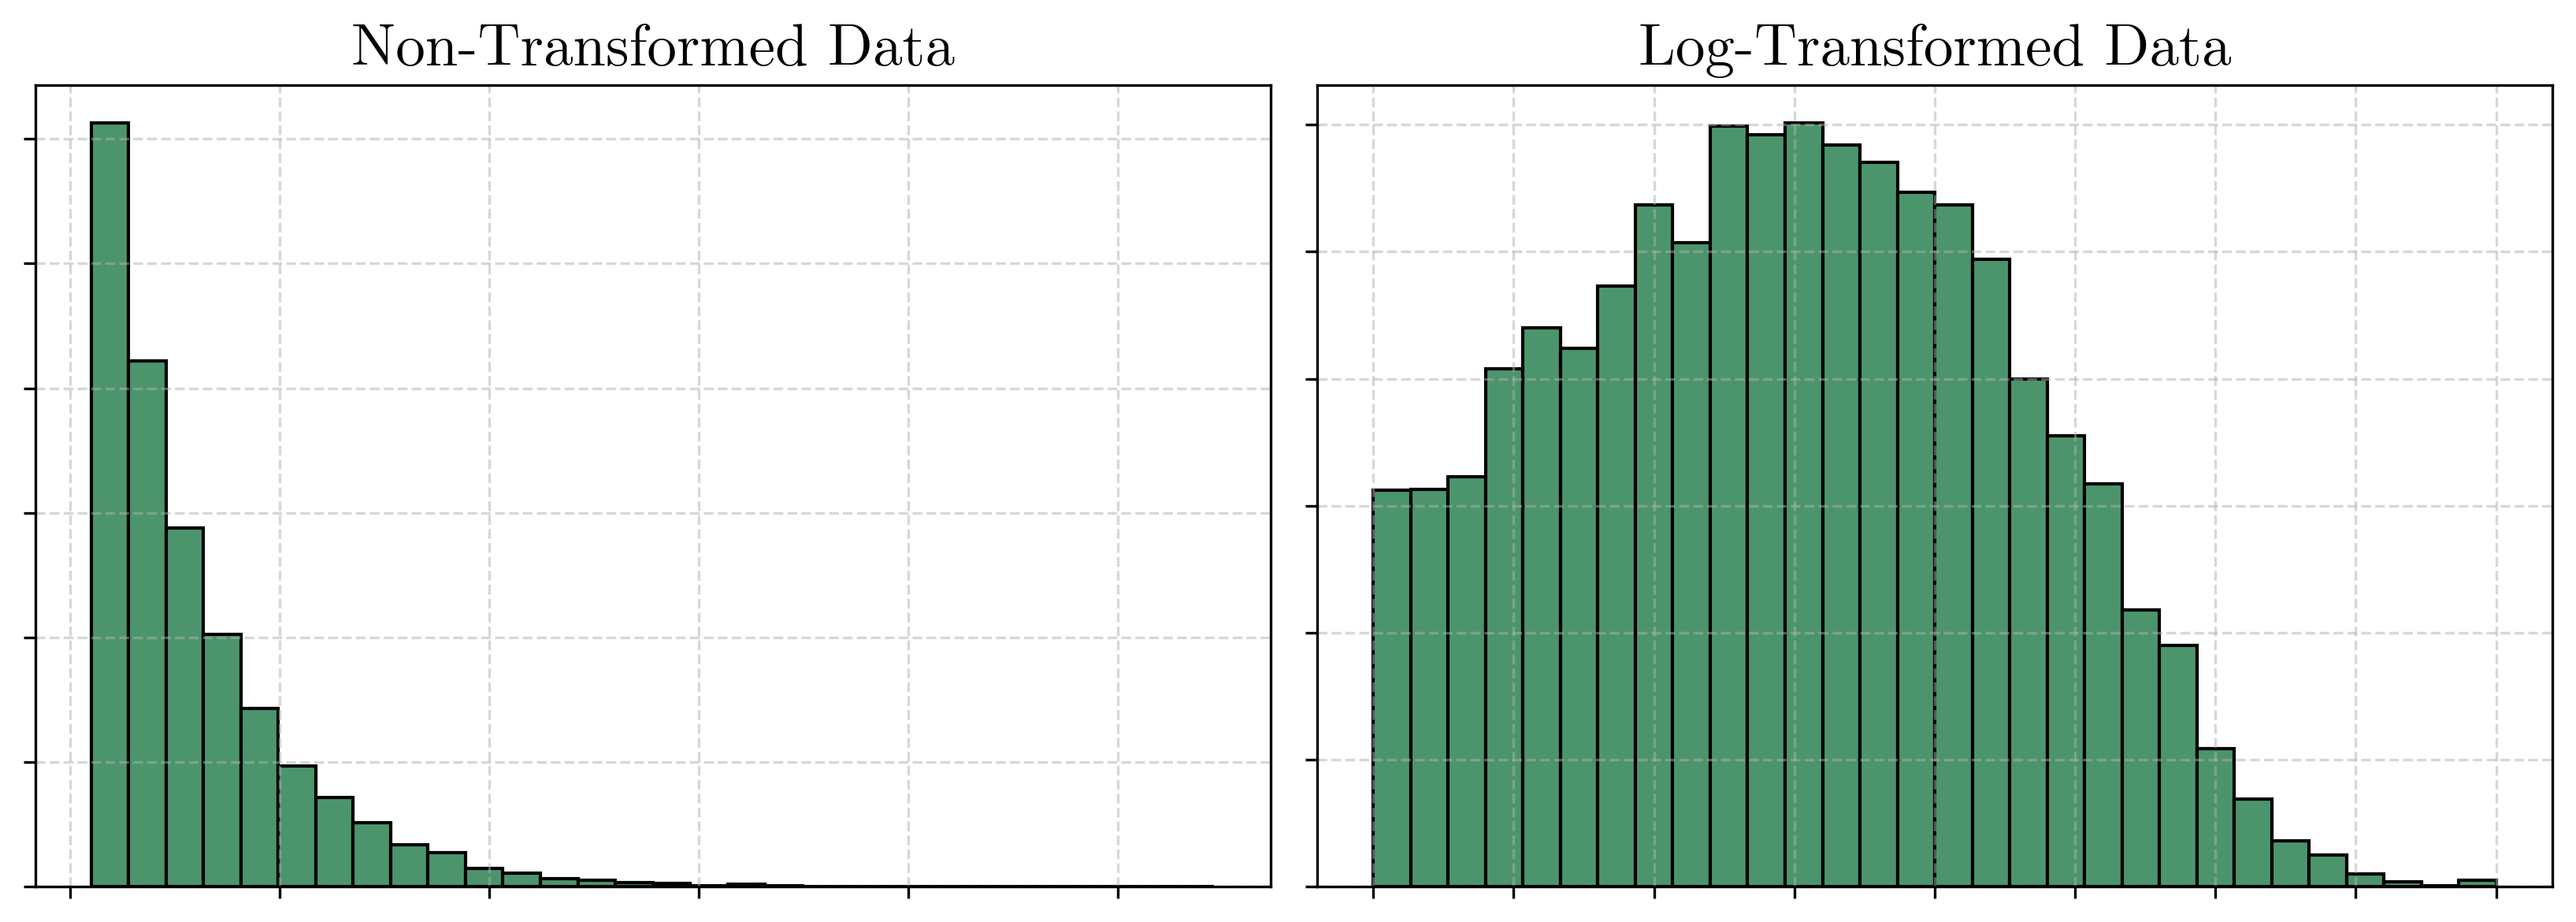

In [4]:
data = np.random.exponential(scale=5.0, size=10000) + 1

epsilon = 1e-6
log_data = np.log(data + epsilon)

plt.figure(figsize=(11, 4), dpi=300)

plt.subplot(1, 2, 1)
plt.hist(data, bins=30, color='#4C956C', edgecolor='black')
plt.title('Non-Transformed Data', fontproperties=cmu_font, fontsize=18)
plt.grid(alpha=0.5, linestyle='--')
plt.tick_params(labelbottom=False, labelleft=False)

plt.subplot(1, 2, 2)
plt.hist(log_data, bins=30, color='#4C956C', edgecolor='black')
plt.title('Log-Transformed Data', fontproperties=cmu_font, fontsize=18)
plt.grid(alpha=0.5, linestyle='--')
plt.tick_params(labelbottom=False, labelleft=False)

plt.tight_layout()
plt.show()

Gaussian Blur example

In [5]:
custom_cmap = LinearSegmentedColormap.from_list(name='mycmap', colors=["#EBF5DF", "#2C6E49"])

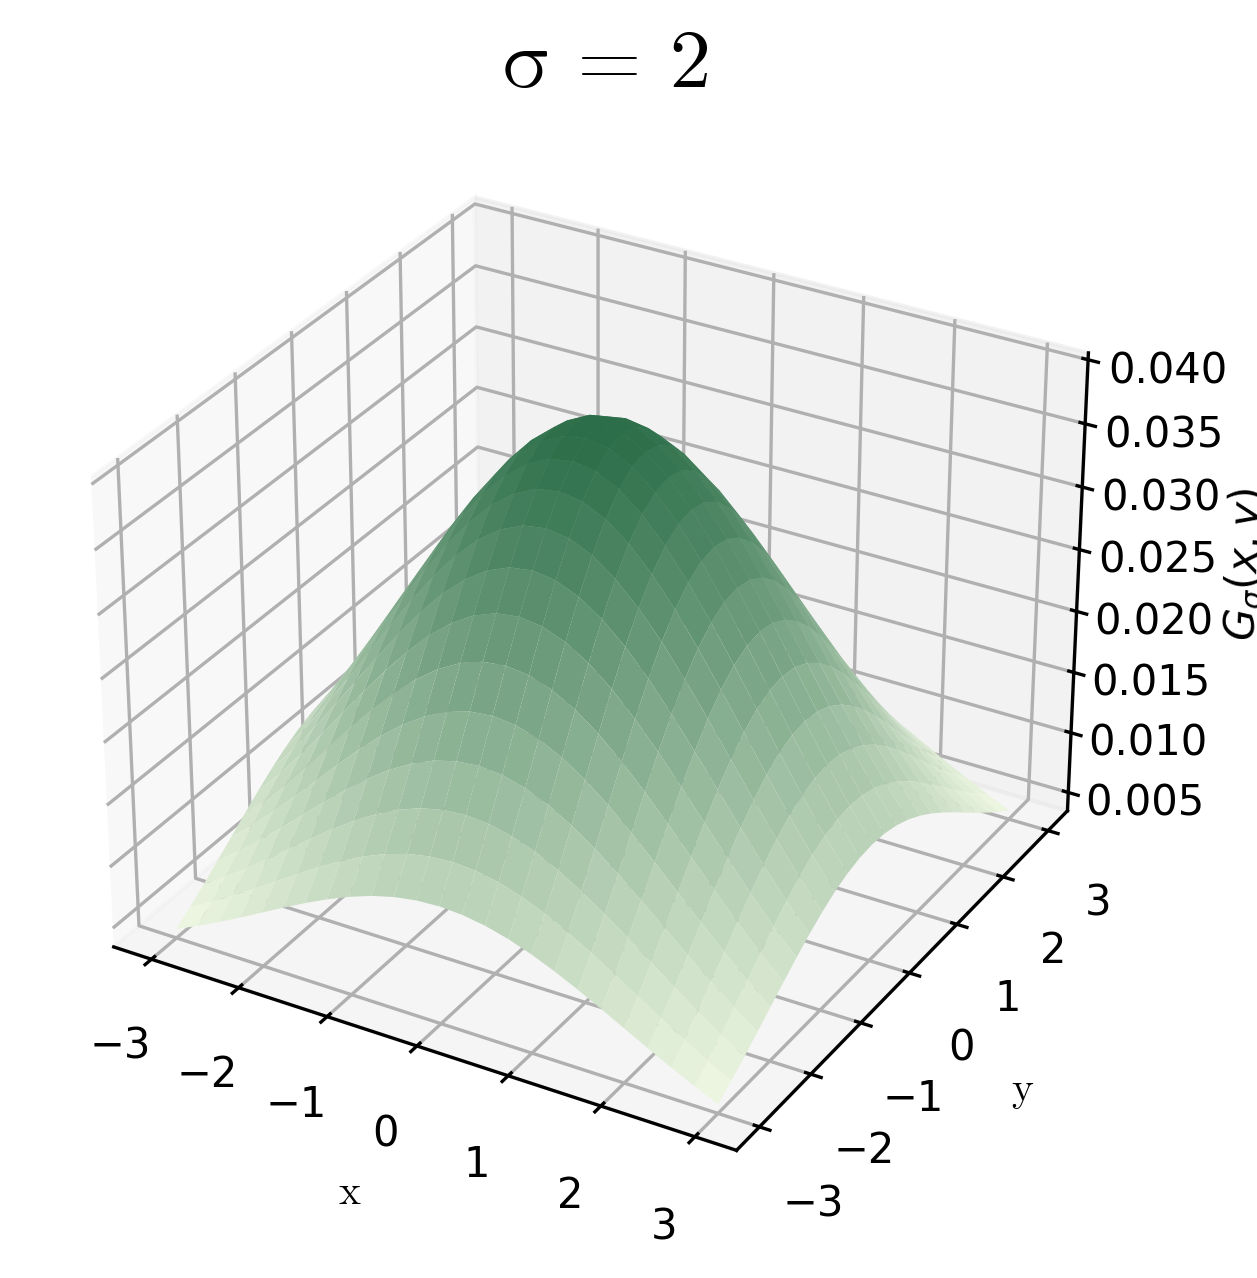

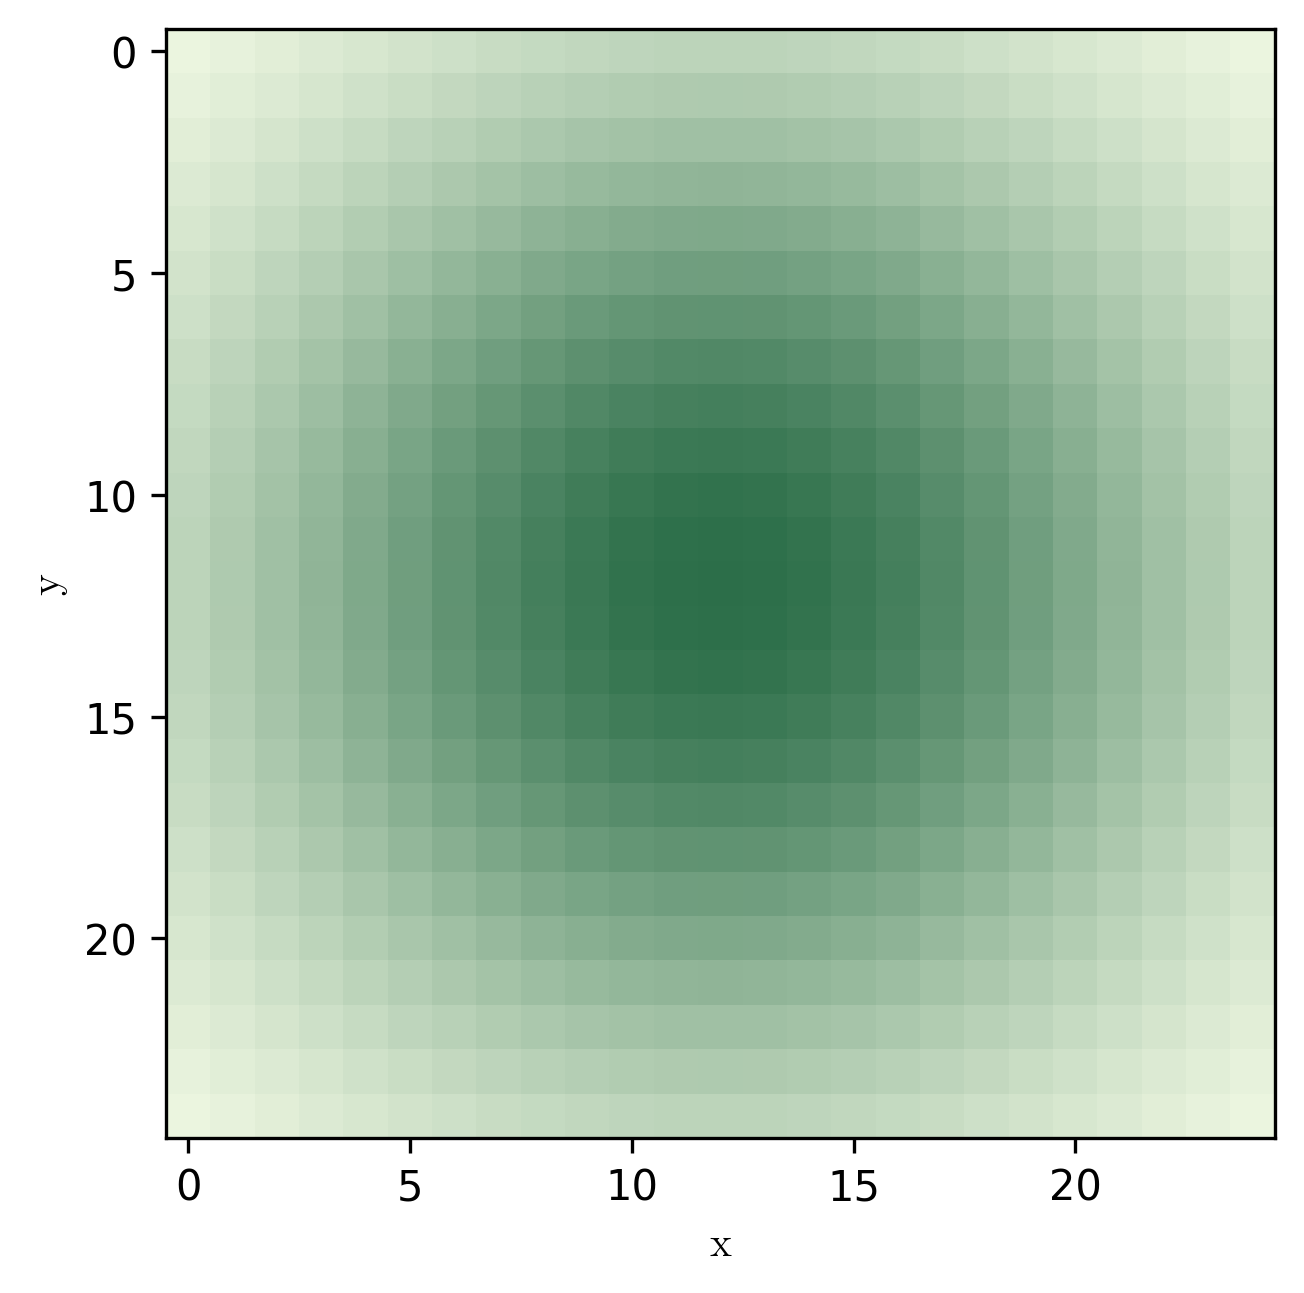

In [6]:
sigma = 2
size = 3
x = np.linspace(-size, size, 25)
y = np.linspace(-size, size, 25)
x, y = np.meshgrid(x, y)

# 2D Gaussian
g = (1 / (2 * np.pi * sigma ** 2)) * np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))

# 3D surface plot
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, g, cmap=custom_cmap, edgecolor='none')
ax.set_title(f'σ = {sigma}', fontproperties=cmu_font, fontsize=20, x=0.52)
ax.set_xlabel('x', fontproperties=cmu_font)
ax.set_ylabel('y', fontproperties=cmu_font)
ax.set_zlabel(r'$G_\sigma(x, y)$', fontproperties=cmu_font)
plt.show()

plt.figure(dpi=300)
plt.imshow(g, cmap=custom_cmap, interpolation='nearest')
plt.xlabel('x', fontproperties=cmu_font)
plt.ylabel('y', fontproperties=cmu_font)
plt.grid(False)
plt.show()

Histogram Equalization example

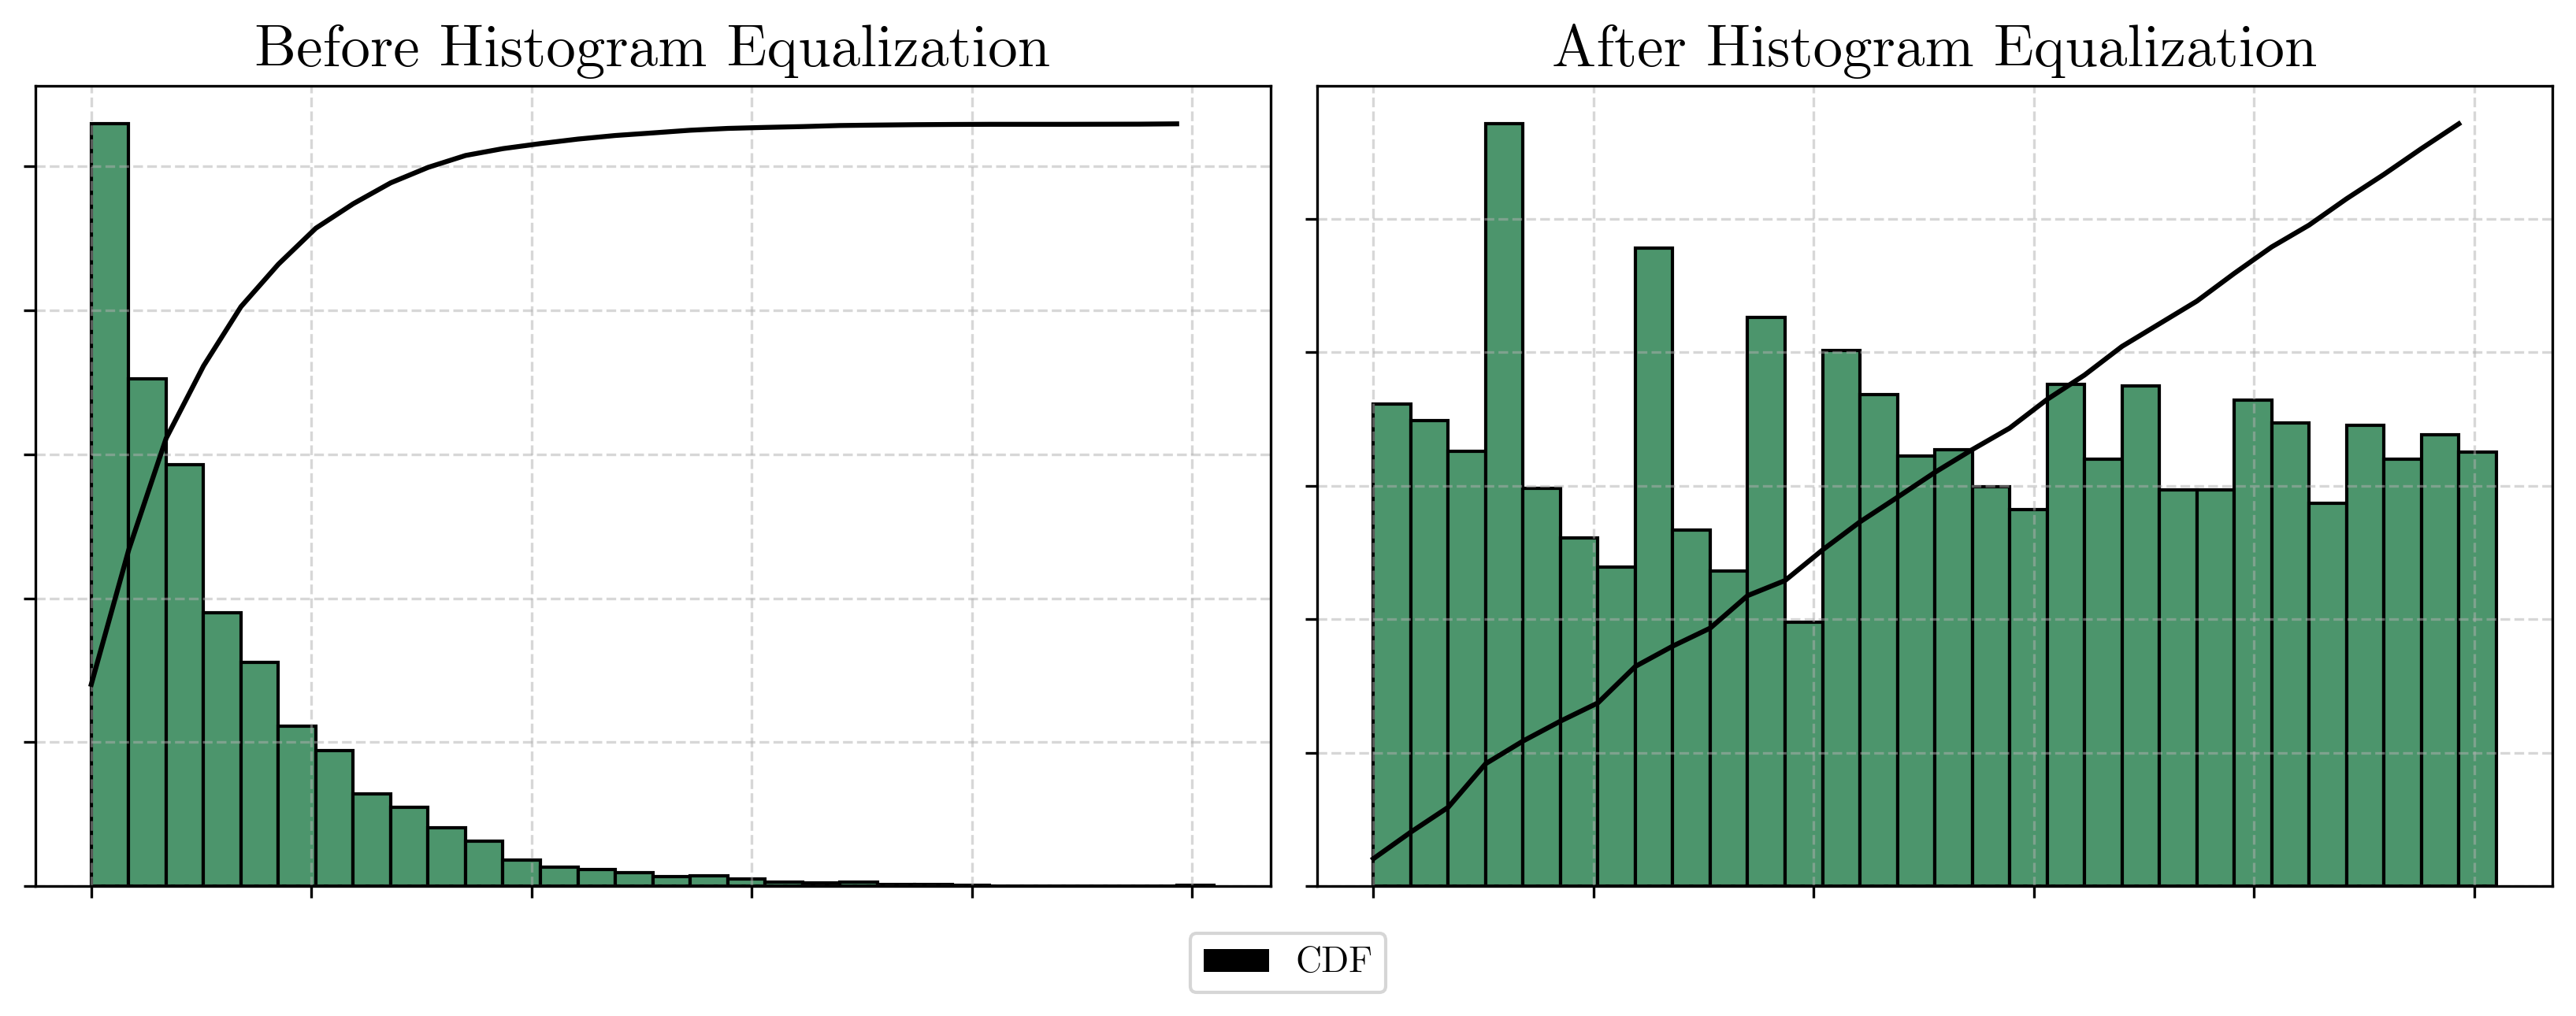

In [7]:
image = np.random.exponential(scale=30.0, size=(100, 100))
image = np.clip(image, 0, 255).astype(np.uint8)

# Histogram Equalization
equalized = cv2.equalizeHist(image)

# Flatten for histogram and CDF
original_flat = image.flatten()
equalized_flat = equalized.flatten()

# Compute histograms and CDFs
hist_orig, bins_orig = np.histogram(original_flat, bins=30, range=(0, 255))
cdf_orig = hist_orig.cumsum()
cdf_orig = cdf_orig / cdf_orig[-1] * hist_orig.max()

hist_eq, bins_eq = np.histogram(equalized_flat, bins=30, range=(0, 255))
cdf_eq = hist_eq.cumsum()
cdf_eq = cdf_eq / cdf_eq[-1] * hist_eq.max()

fig, axes = plt.subplots(1, 2, figsize=(11, 4), dpi=300)

axes[0].hist(original_flat, bins=30, color='#4C956C', edgecolor='black')
axes[0].plot(bins_orig[:-1], cdf_orig, color='black', linewidth=1.5)
axes[0].set_title('Before Histogram Equalization', fontproperties=cmu_font, fontsize=18)
axes[0].grid(alpha=0.5, linestyle='--')
axes[0].tick_params(labelbottom=False, labelleft=False)

axes[1].hist(equalized_flat, bins=30, color='#4C956C', edgecolor='black')
axes[1].plot(bins_eq[:-1], cdf_eq, color='black', linewidth=1.5)
axes[1].set_title('After Histogram Equalization', fontproperties=cmu_font, fontsize=18)
axes[1].grid(alpha=0.5, linestyle='--')
axes[1].tick_params(labelbottom=False, labelleft=False)

legend_patch = Patch(facecolor='black', label='CDF')
legend = fig.legend(handles=[legend_patch], loc='lower center', bbox_to_anchor=(0.5, -0.08),
                    frameon=True)
for text in legend.get_texts():
    text.set_fontproperties(cmu_font)
    text.set_fontsize(11)

plt.tight_layout()
plt.show()

Comparison of different preprocessing methods applied to the peripherin channel

In [8]:
peripherin_markers = load_tiff_files('data/peripherin_marker')

In [9]:
tma_case = get_original_tma_case(tma_case_anonymized=2)  # Example 2: get_original_tma_case(tma_case_anonymized=185)

In [10]:
peripherin_marker = torch.tensor(peripherin_markers[tma_case], dtype=torch.float32)

preprocessed_images = {
    "Min-Max Normalization": MinMaxNormalize()(peripherin_marker),
    "Log Transformation": LogTransform()(peripherin_marker),
    "Percentile Normalization": PercentileNormalize()(peripherin_marker),
    "Intensity Clipping": ClipIntensity()(peripherin_marker),
    "Intensity Clipping +\nMin-Max Normalization": MinMaxNormalize()(ClipIntensity()(peripherin_marker)),
    "Gaussian Blur +\nHistogram Equalization+\nMin-Max Normalization": MinMaxNormalize()(
        HistogramEqualization()(GaussianBlur()(peripherin_marker)))[0]
}

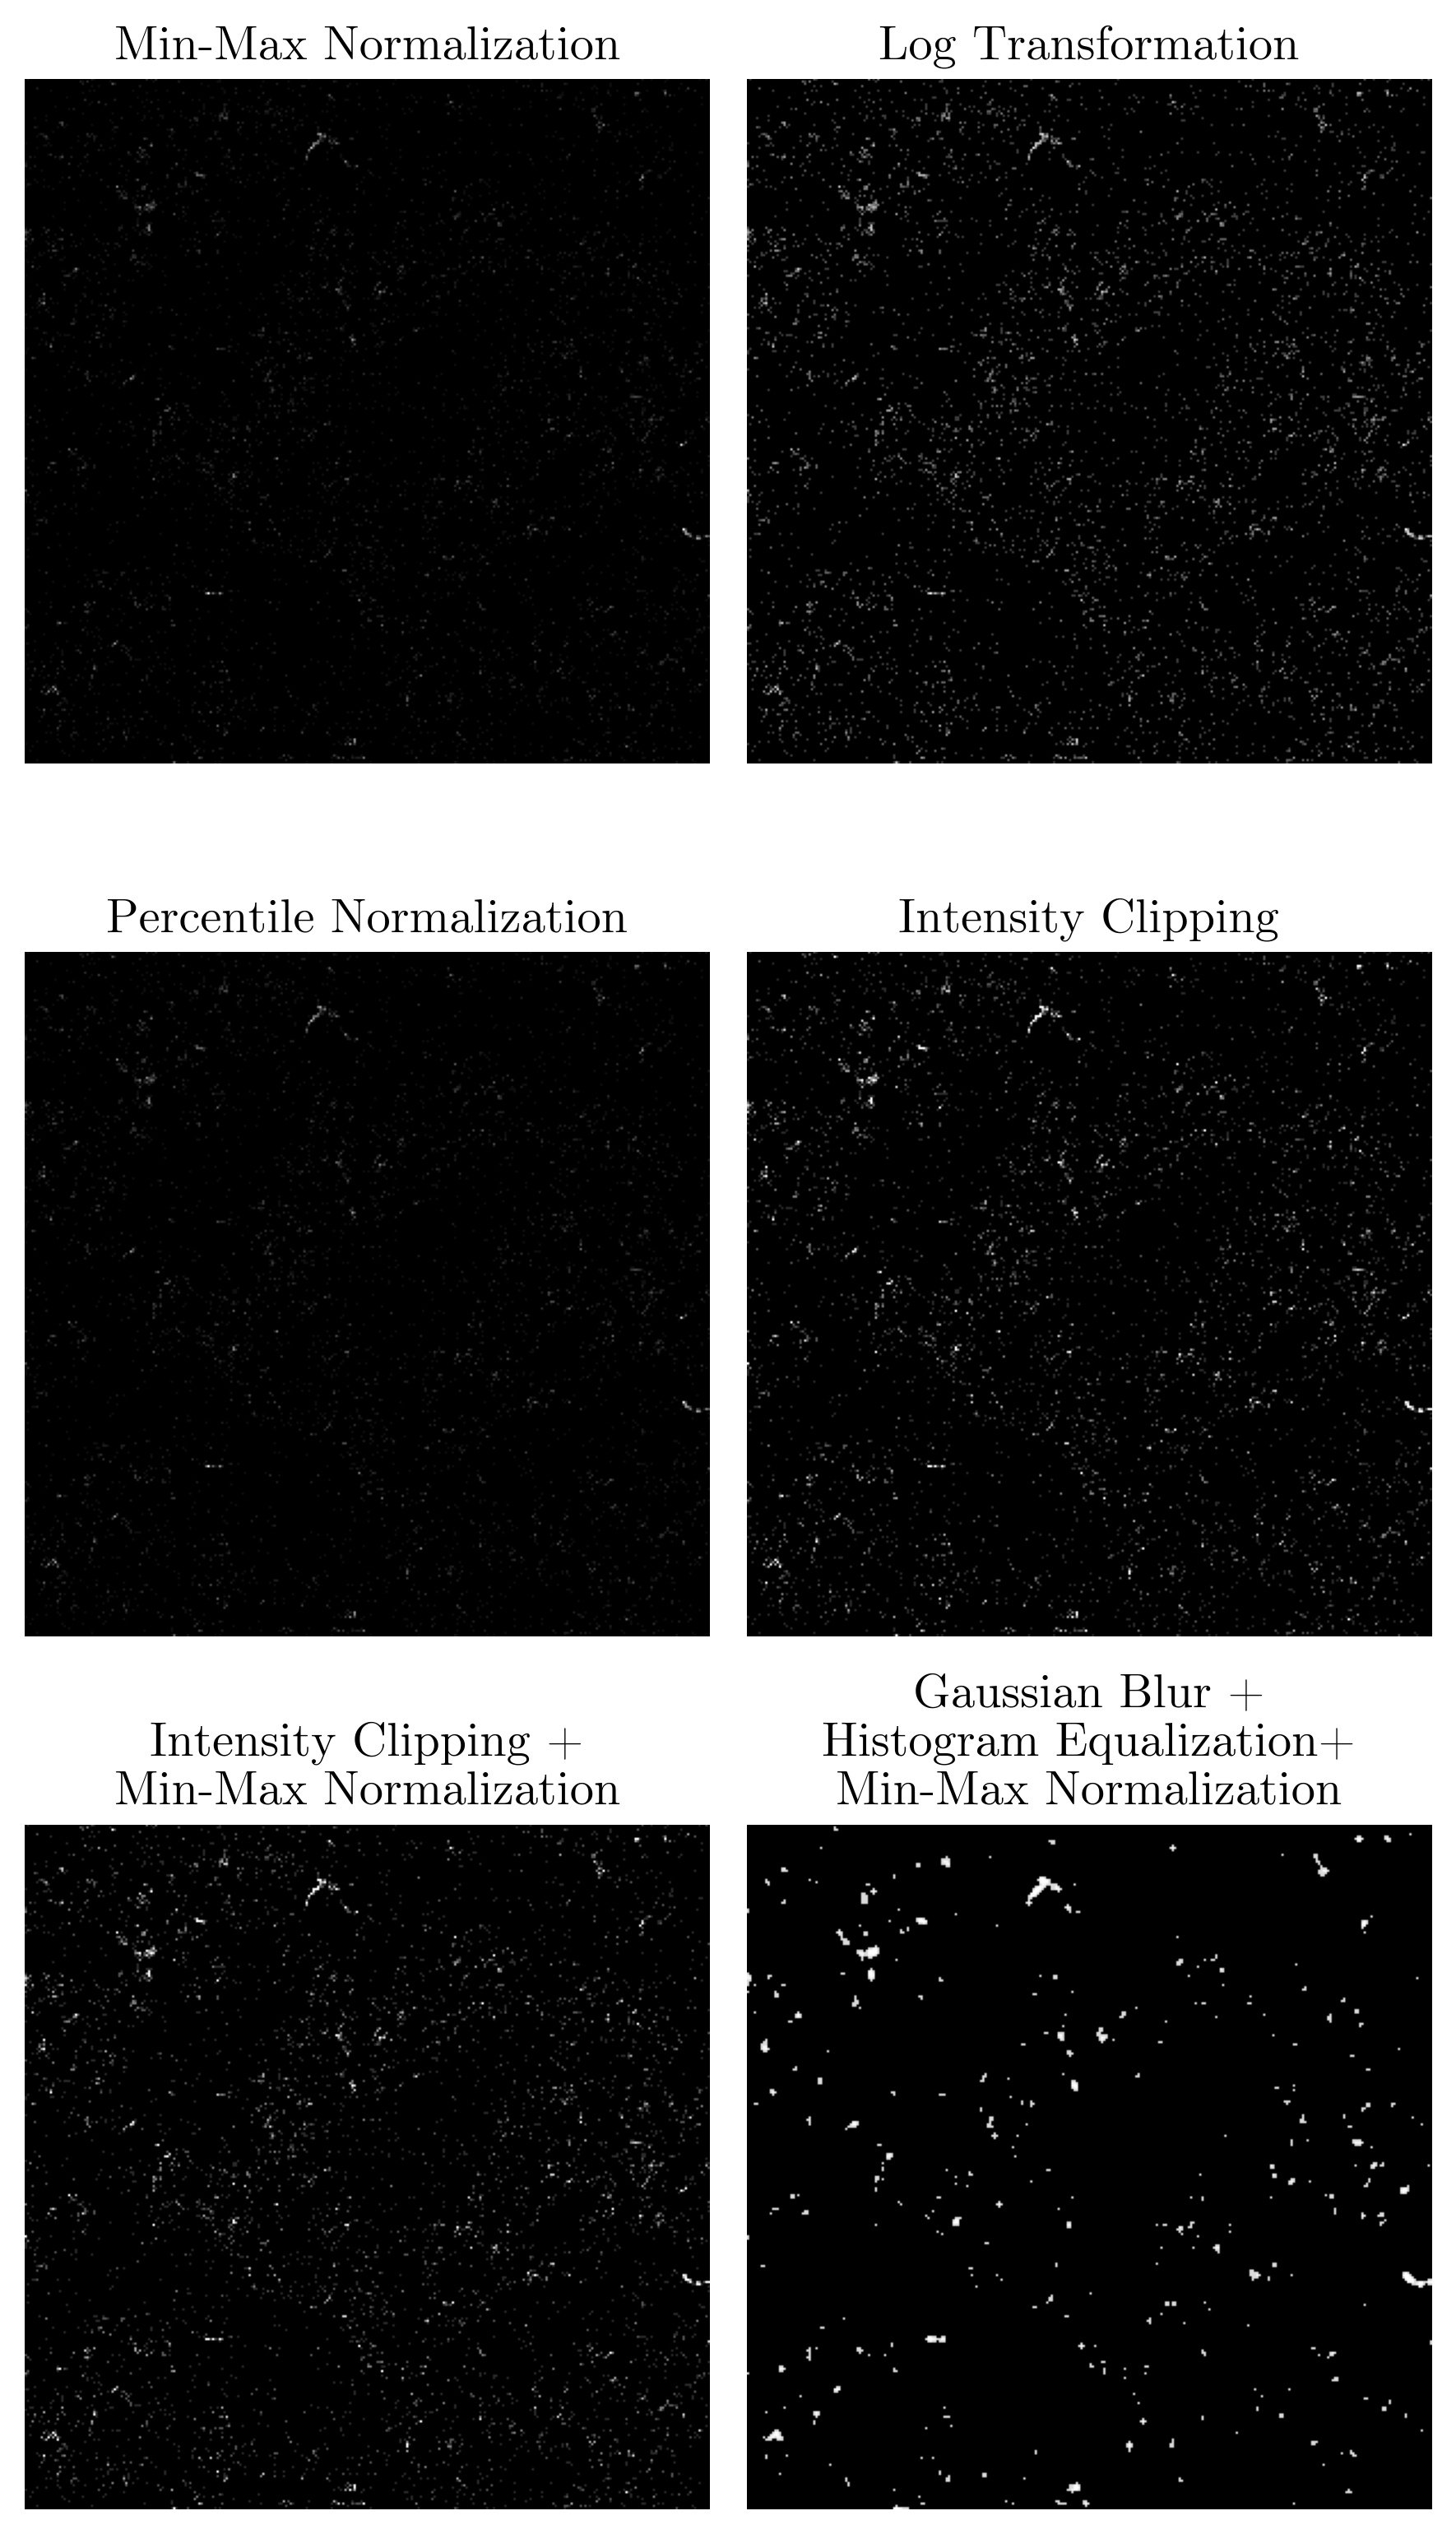

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(6, 10.5), dpi=300)
axes = axes.flatten()

for idx in range(6):
    ax = axes[idx]
    method_name = list(preprocessed_images.keys())[idx]
    image = preprocessed_images[method_name].numpy()

    ax.imshow(image[200:500, 400:700], cmap='gray')
    ax.set_title(method_name, fontproperties=cmu_font, fontsize=14)
    ax.axis('off')

fig.tight_layout()

Comparison of nerve masks used for training and nerve masks predicted by the model

In [12]:
loose_masks = load_tiff_files('data/bin_nerve_mask')
pred_masks = load_tiff_files('results/filtered_bin_nerve_mask')

In [13]:
# Top 3 validation cases by the number of nerve fibers
tma_case1 = get_original_tma_case(tma_case_anonymized=54)
tma_case2 = get_original_tma_case(tma_case_anonymized=313)
tma_case3 = get_original_tma_case(tma_case_anonymized=299)

In [14]:
peripherin1 = torch.tensor(peripherin_markers[tma_case1], dtype=torch.float32)
peripherin2 = torch.tensor(peripherin_markers[tma_case2], dtype=torch.float32)
peripherin3 = torch.tensor(peripherin_markers[tma_case3], dtype=torch.float32)

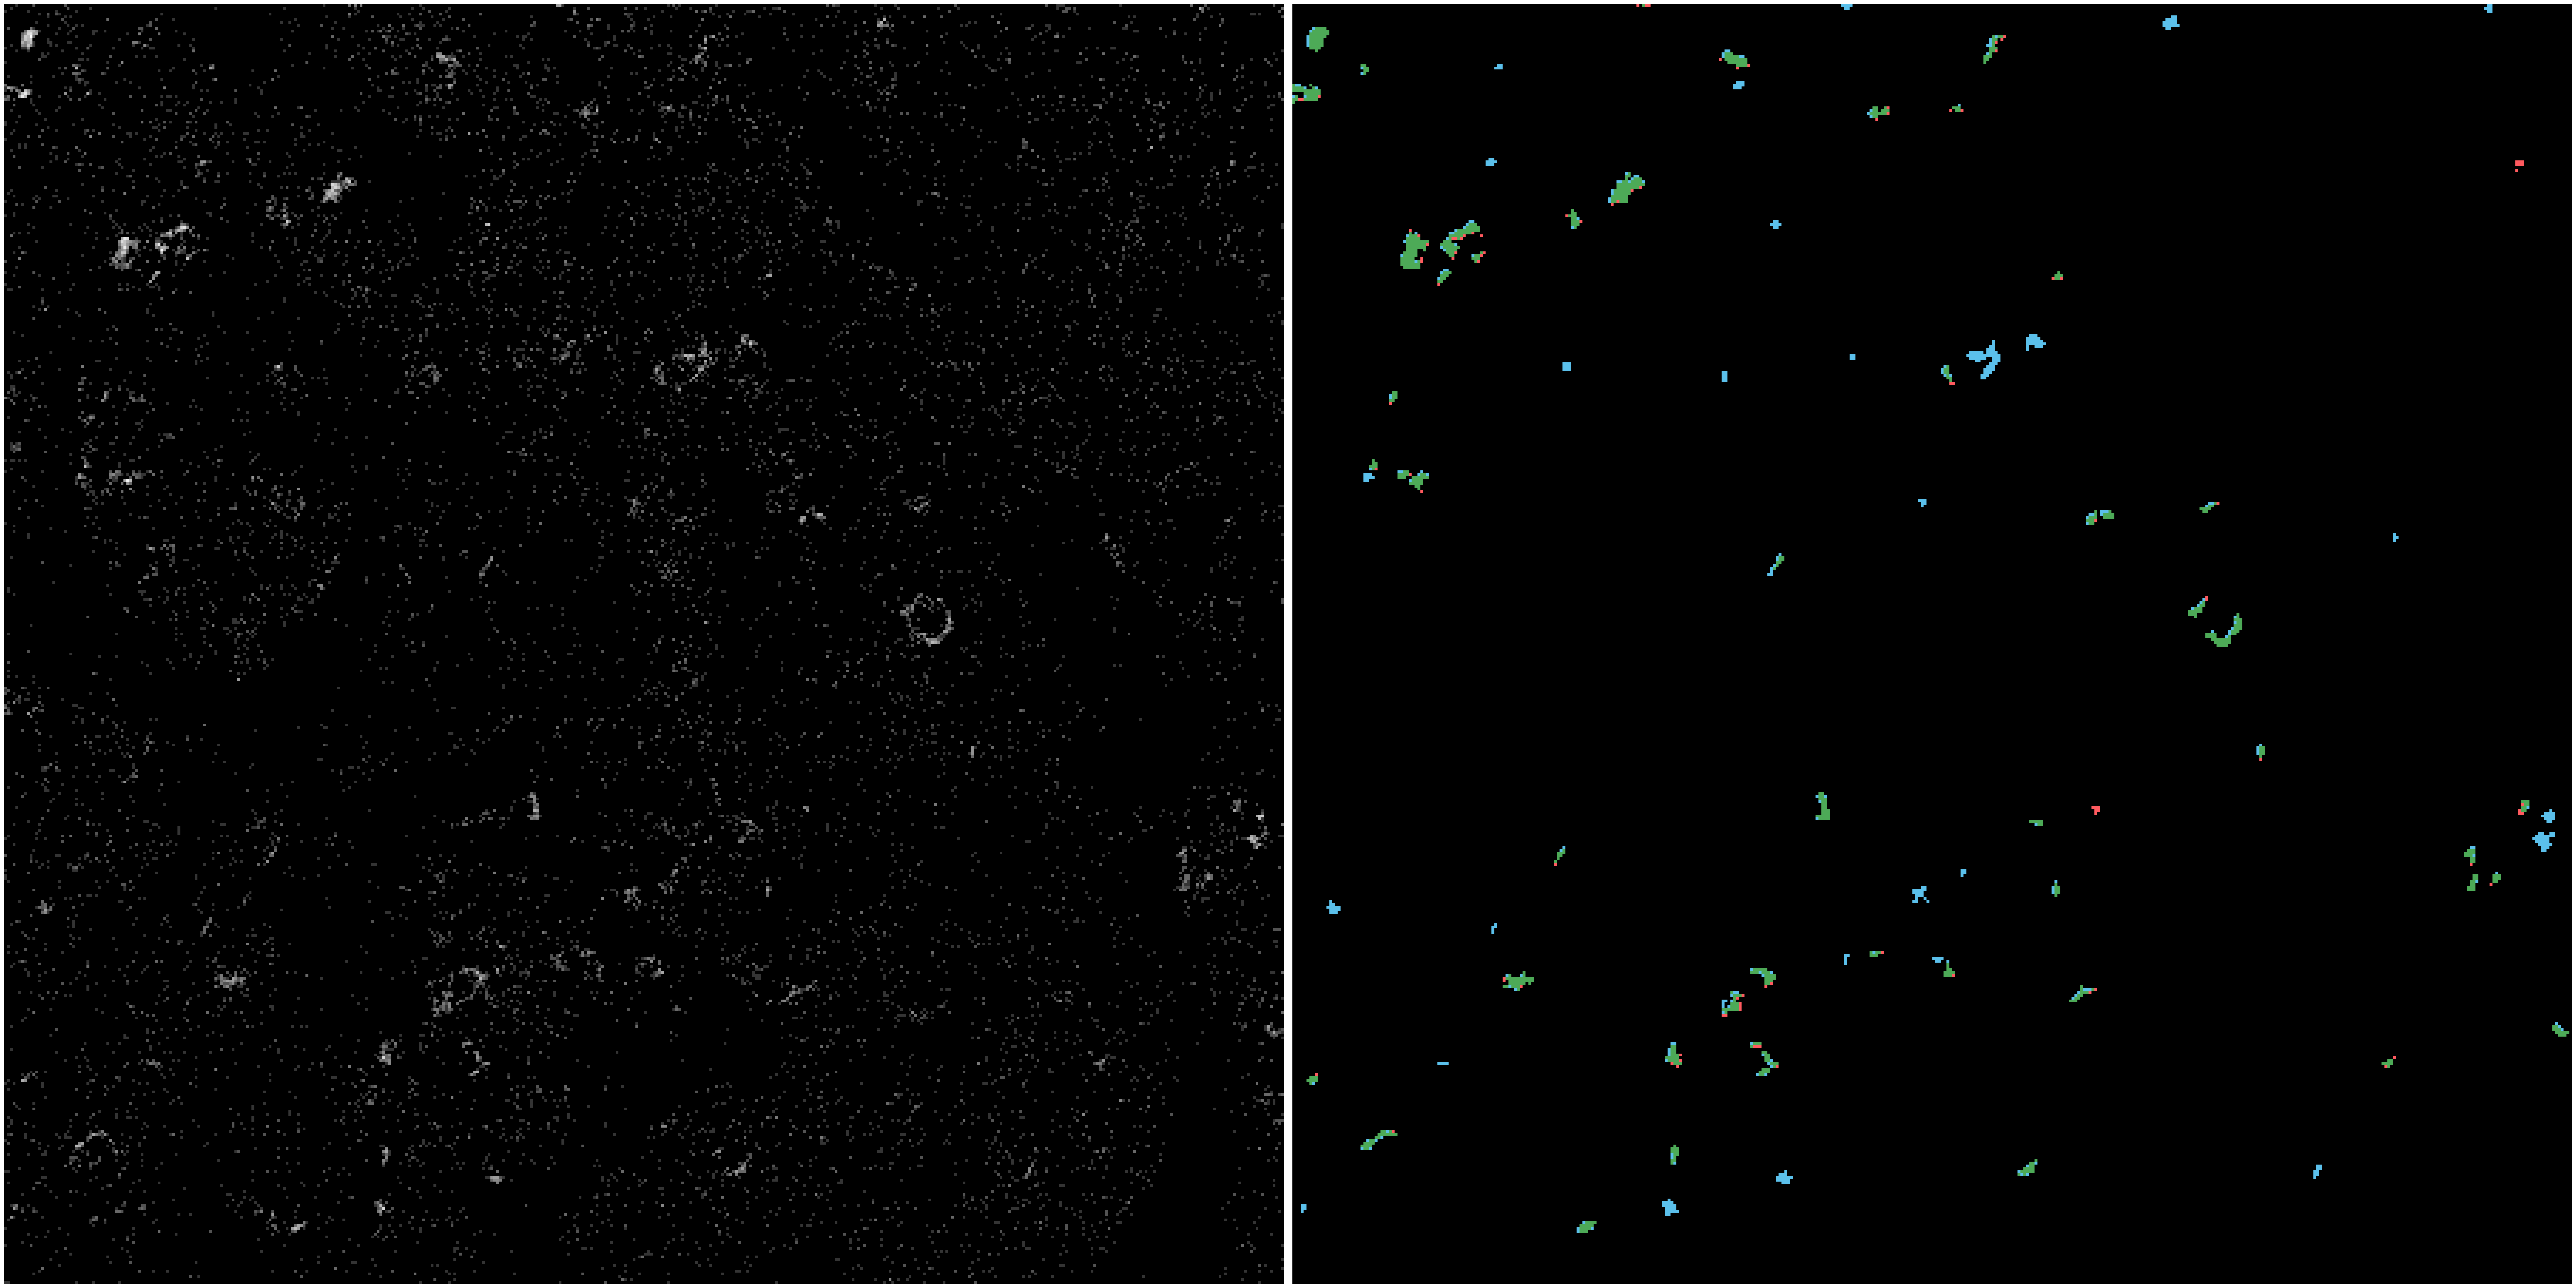

In [15]:
viz.peripherin_overlay_comparison(LogTransform()(peripherin1)[50:500, 50:500],
                                  loose_masks[tma_case1][50:500, 50:500],
                                  pred_masks[tma_case1][50:500, 50:500])

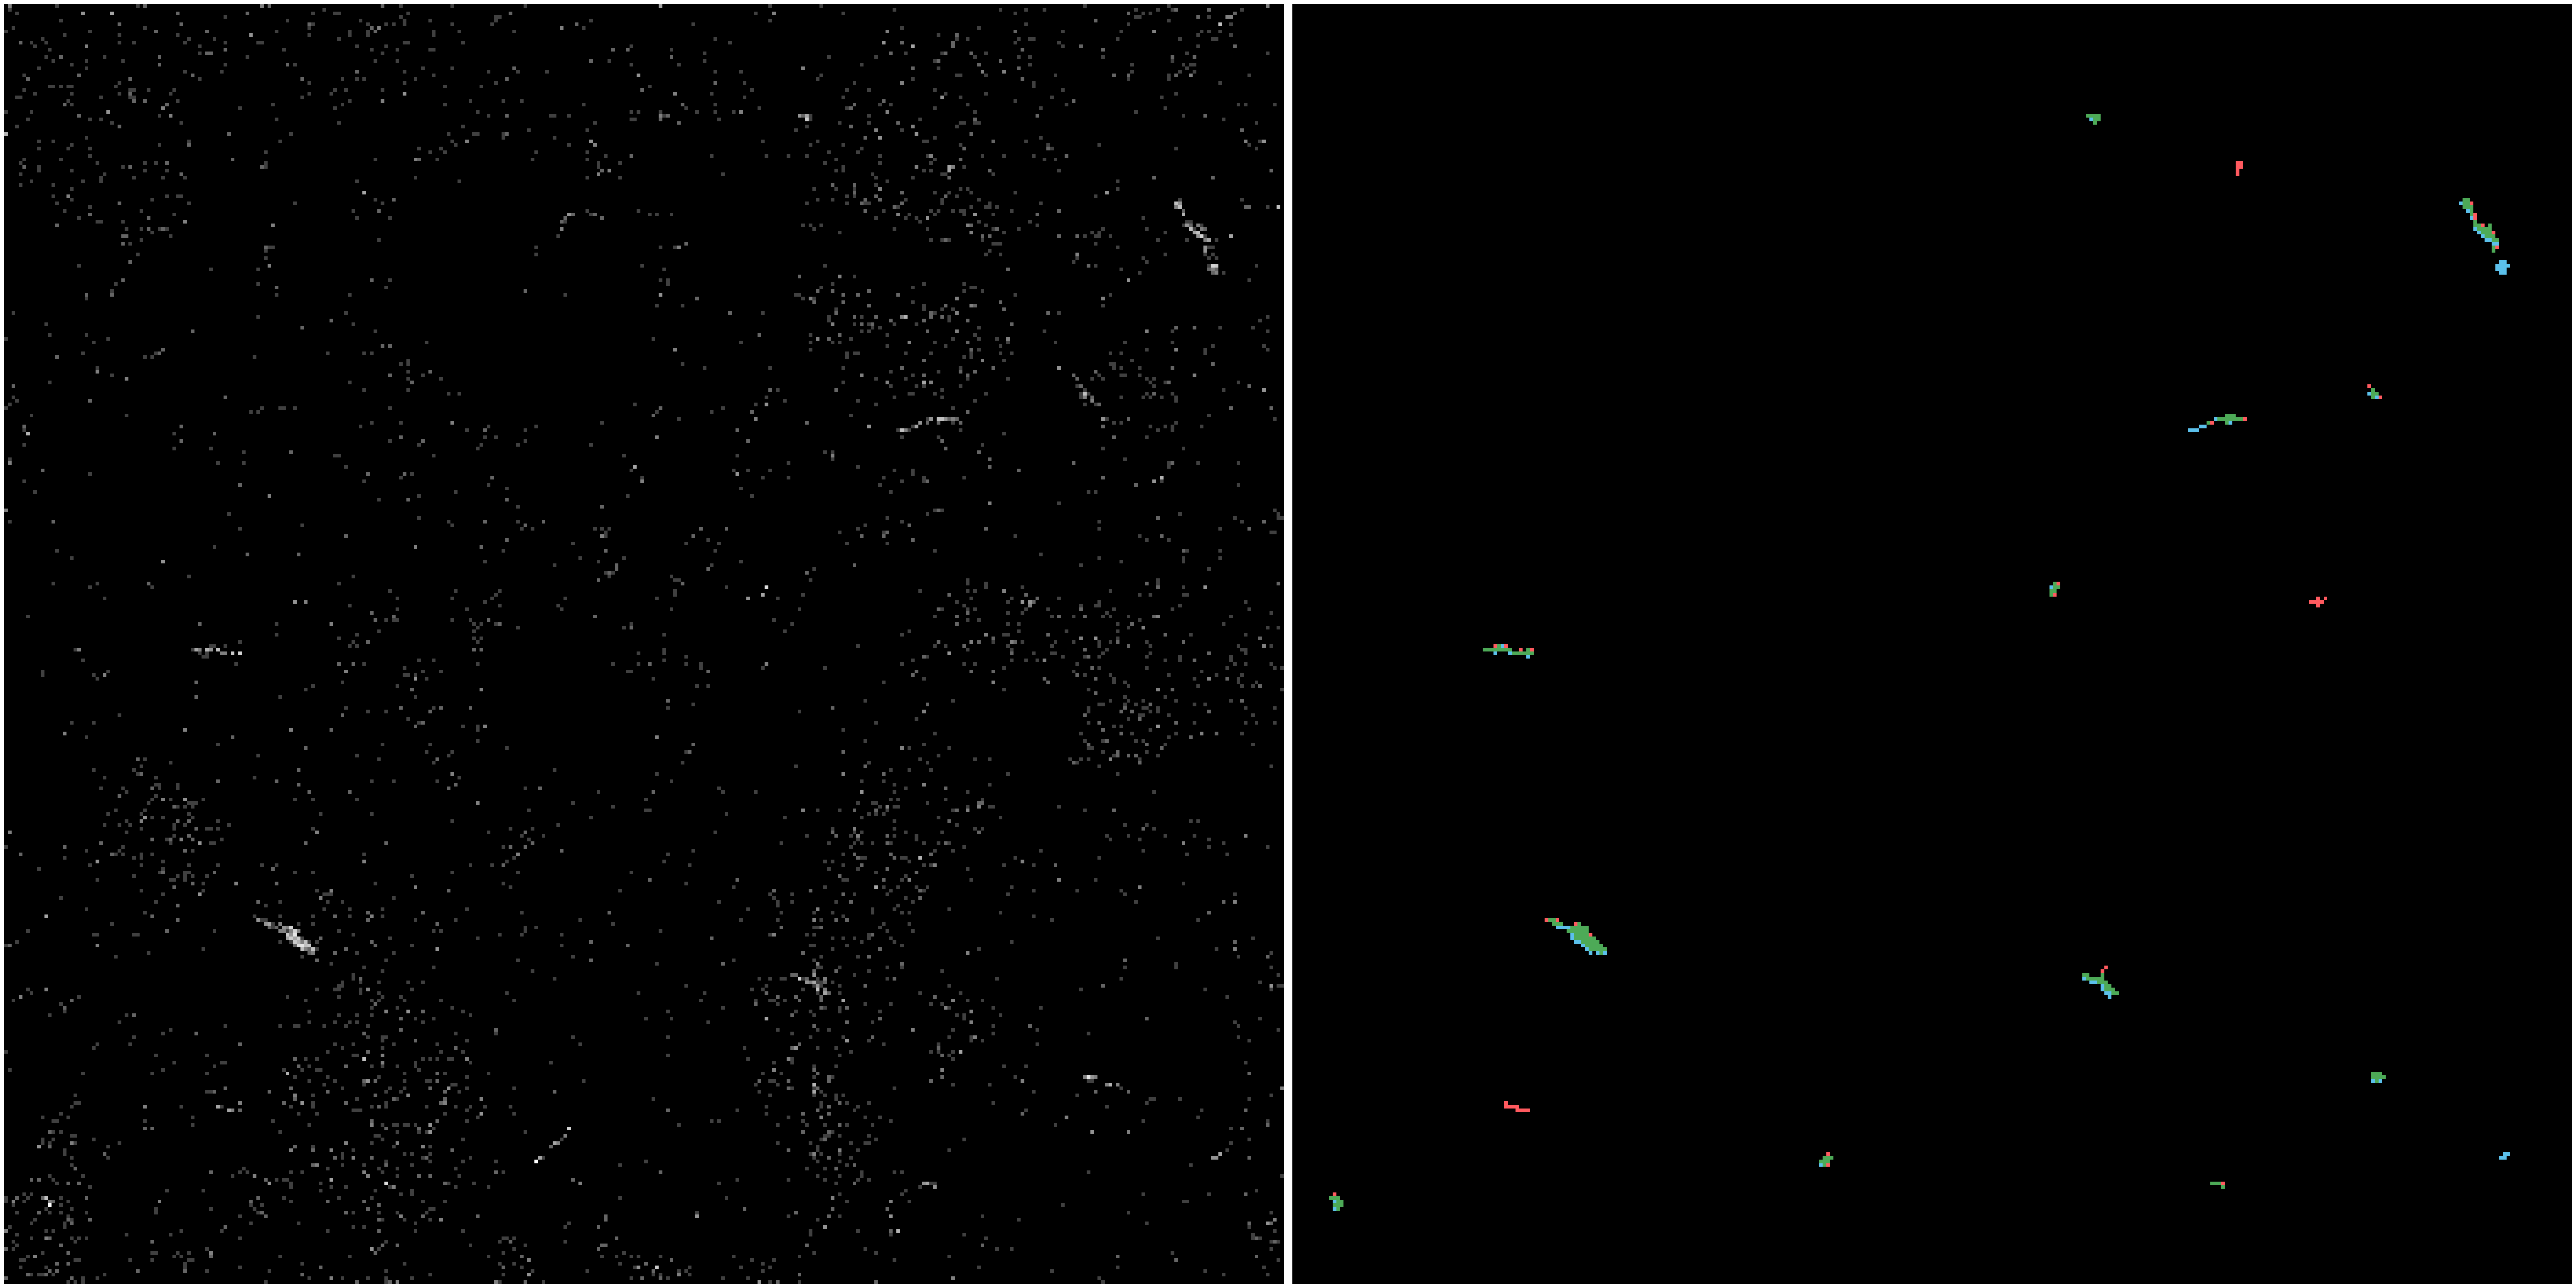

In [16]:
viz.peripherin_overlay_comparison(LogTransform()(peripherin2)[400:750, 50:400],
                                  loose_masks[tma_case2][400:750, 50:400],
                                  pred_masks[tma_case2][400:750, 50:400])

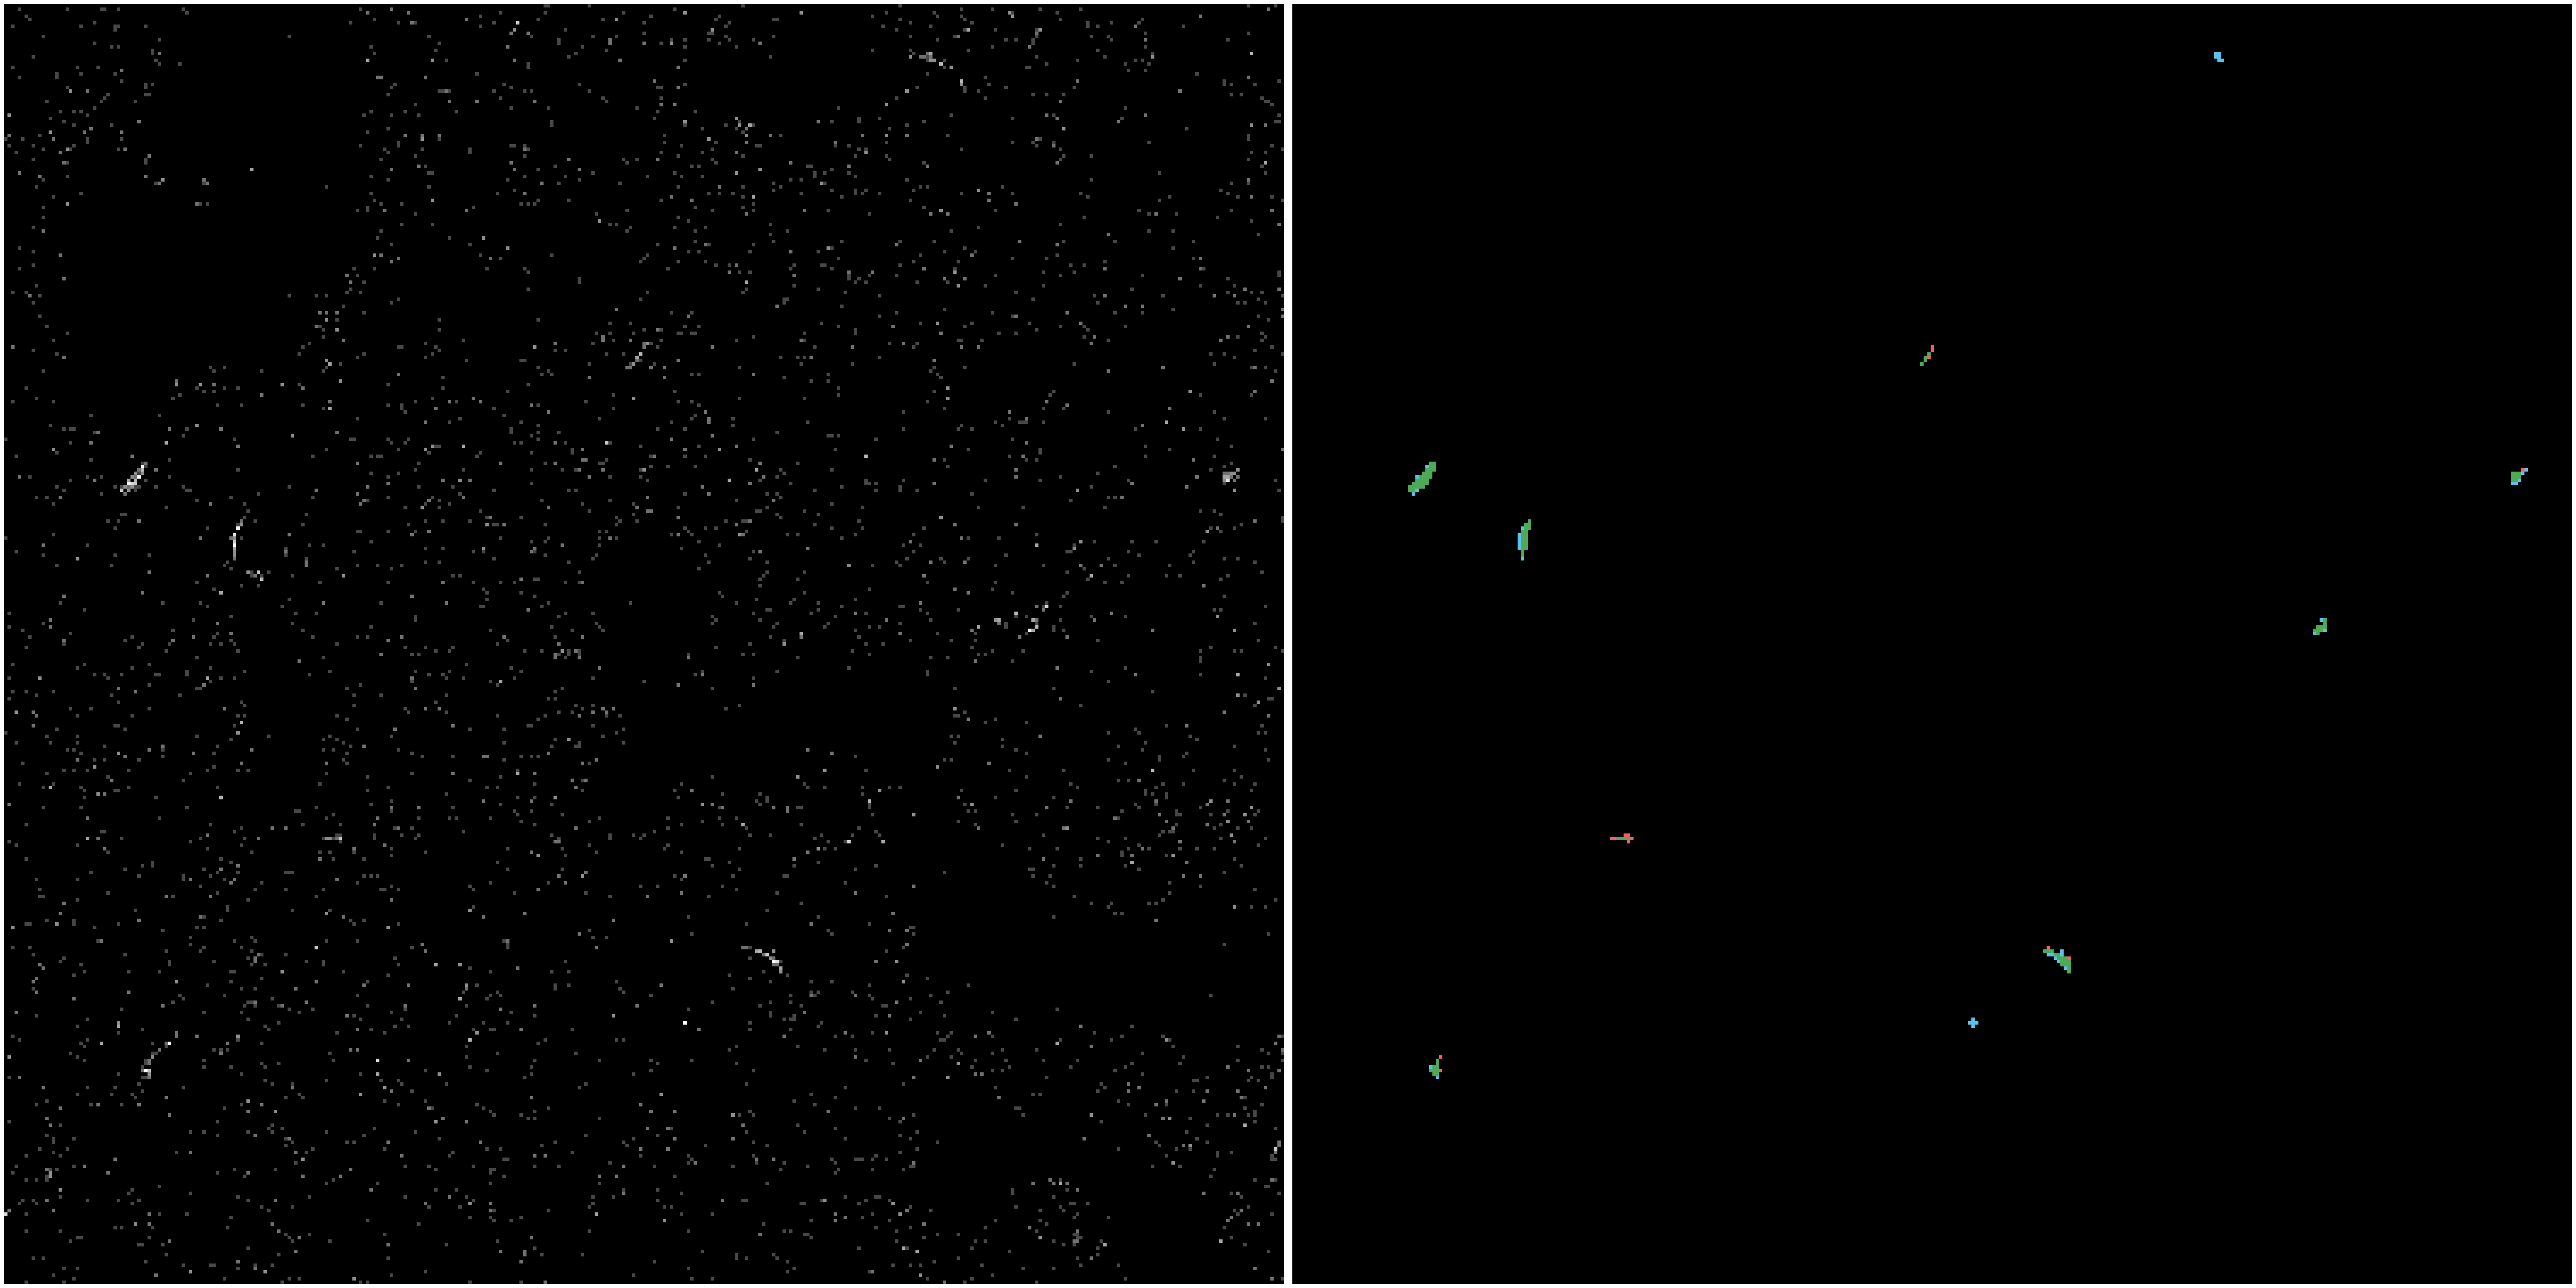

In [17]:
viz.peripherin_overlay_comparison(LogTransform()(peripherin3)[425:800, 75:450],
                                  loose_masks[tma_case3][425:800, 75:450],
                                  pred_masks[tma_case3][425:800, 75:450])